In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline

5.218575355567207

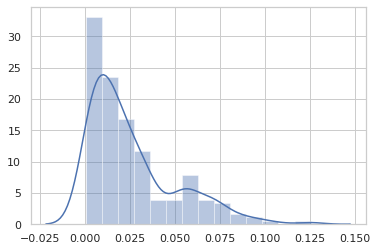

In [65]:
var = sts.expon() #loc=0, scale=1)


standard_rate = 40.
sim_n, spikes = 1_000, 200
a = (np.random.exponential(scale=1, size=(spikes, sim_n)) + .01) / standard_rate
sns.distplot(a[:, 0])

a[:, 0].sum()

In [66]:
%%time

import time
from queue import heappush, heappop

pq = list()
t0 = time.monotonic()

for t in range(sim_n):
    heappush(pq, (a[0, t] + t0, t))

i, i_spike = 1, [1]*sim_n
k = sim_n * spikes // 10
lag = .0
spin_cnt = 0

while len(pq):
    t = time.monotonic()
    if pq[0][0] <= t:
        ct, d = heappop(pq)
        cur_lag = t - ct
        lag += cur_lag
        
        if i_spike[d] < spikes:
            heappush(pq, (a[i_spike[d], d] + t, d))
            i_spike[d] += 1
            i += 1
            
            if i % k == 0:
                print(t - t0, cur_lag, i, d)
    else:
        spin_cnt += 1
        
print(spin_cnt / 1000_000, lag * 1000. / (sim_n * spikes))

0.5075107839656994 1.51805579662323e-07 20000 533
1.0043891829554923 1.5174737200140953e-07 40000 840
1.512583417003043 1.417938619852066e-07 60000 671
2.018737986974884 1.5186727978289127e-05 80000 593
2.524747198971454 1.1868542060256004e-06 100000 613
3.025971225986723 3.3638207241892815e-07 120000 316
3.5271793229621835 2.860906533896923e-07 140000 346
4.0340963209746405 2.6694033294916153e-06 160000 760
4.557198386988603 1.0632211342453957e-06 180000 860
11.3379 0.004204631334869191
CPU times: user 5.98 s, sys: 3.97 ms, total: 5.98 s
Wall time: 5.98 s
